In [8]:
import wfdb
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [ ]:
# 1) Cargar el registro desde PhysioNet 
db_dir      = "i-care/2.0/training/0427" 
record_name = "0427_001_004_ECG"    
rec         = wfdb.rdrecord(record_name, pn_dir=db_dir)

fs   = rec.fs                  # frecuencia de muestreo 
ecg  = rec.p_signal[:, 0]      # primer canal
t    = np.arange(len(ecg)) / fs

print(f"Frecuencia de muestreo: {fs} Hz")
print(f"Nº de muestras totales: {len(ecg)}")
print(f"Canales disponibles   : {rec.sig_name}")

Frecuencia de muestreo: 500 Hz
Nº de muestras totales: 1800000
Canales disponibles   : ['ECG']


In [ ]:

# Se selecciona un segmento de 5 s
seg_dur   = 5           
seg_start = 0           
i_ini     = int(seg_start     * fs)
i_fin     = int((seg_start+seg_dur) * fs)

ecg_seg = ecg[i_ini:i_fin]
t_seg   = t[i_ini:i_fin]

In [7]:
# Algoritmo Pan-Tompkins e  índices de picos R 

def bandpass(signal, fs, low=5.0, high=15.0, order=1):
    nyq = 0.5 * fs
    b, a = sig.butter(order, [low/nyq, high/nyq], btype='band')
    return sig.filtfilt(b, a, signal)

# 4.1  Filtrado 5-15 Hz (realza el complejo QRS y atenúa el ruido)
ecg_f = bandpass(ecg_seg, fs)

# 4.2  Derivada
diff   = np.diff(ecg_f, prepend=ecg_f[0])

# 4.3  Cuadrado
squared = diff**2

# 4.4  Integración por ventana móvil (150 ms ≈ 0.15 s)
win = int(0.150 * fs)
integ = np.convolve(squared, np.ones(win)/win, mode='same')

# 4.5  Umbral adaptativo + período refractario (200 ms)
thresh = 0.05 * np.max(integ)          # 5 % del máximo
refrac = int(0.200 * fs)               # 200 ms
peaks, _ = sig.find_peaks(integ, height=thresh, distance=refrac)

# 4.6  Afinar cada pico: máximo local de la señal filtrada ±100 ms
def refine(peaks, sig_filt, fs, win_ms=100):
    w = int((win_ms/1000) * fs)
    refined = []
    for p in peaks:
        a = max(0, p-w)
        b = min(len(sig_filt), p+w)
        refined.append(a + np.argmax(sig_filt[a:b]))
    return np.array(refined, dtype=int)

r_idx   = refine(peaks, ecg_f, fs)
r_times = t_seg[r_idx]

print(f"Picos R detectados: {len(r_idx)}")

Picos R detectados: 4


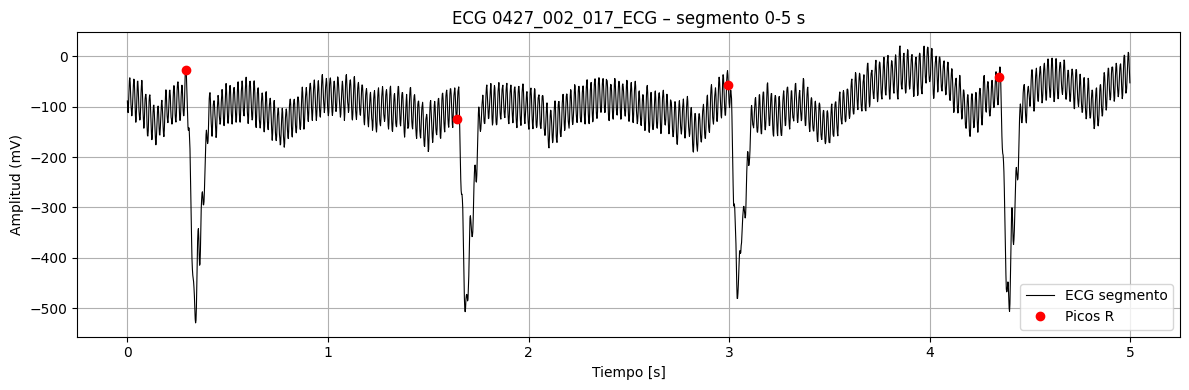

In [ ]:
# Gráfica de la señal cruda con picos R

plt.figure(figsize=(12, 4))
plt.plot(t_seg, ecg_seg, 'k', lw=0.8, label='ECG segmento')
plt.plot(r_times, ecg_seg[r_idx], 'ro', label='Picos R')
plt.title(f'ECG {record_name} – segmento {seg_start}-{seg_start+seg_dur} s')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud (mV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

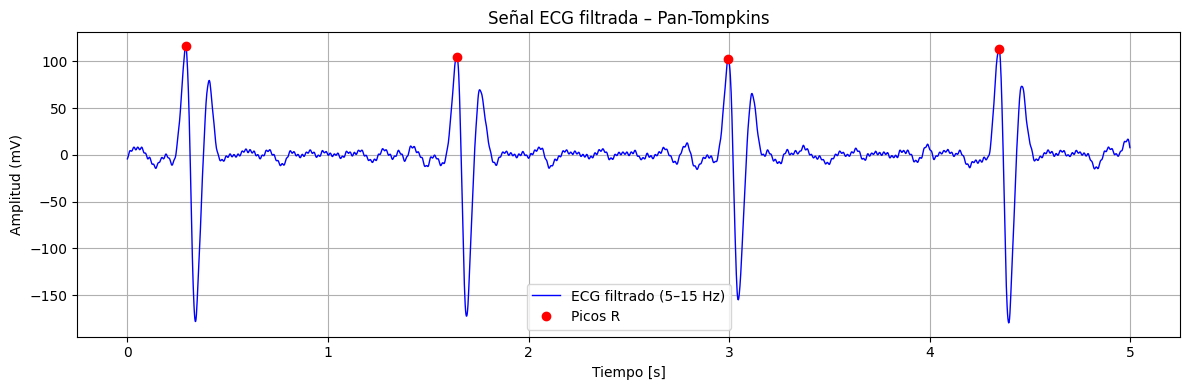

In [ ]:

# Gráfica de la señal filtrada con picos R
plt.figure(figsize=(12, 4))
plt.plot(t_seg, ecg_f, 'b', lw=1, label='ECG filtrado (5–15 Hz)')
plt.plot(r_times, ecg_f[r_idx], 'ro', label='Picos R')
plt.title('Señal ECG filtrada – Pan-Tompkins')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud (mV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()